# **Deep Learning Homework 6: *Variational Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---

In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset. In developing the VAE we also explore how to develop an ad-hoc layer and a custom training step.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.


### Load Dataset
We load the MNIST dataset, using `tf.keras.datasets`. The dataset contains 60,000 training grayscale images and 10,000 testing image of handwritten digits.

In [10]:
# load necessary libriaries and functions
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.subplot(1, 2, 1)
  plt.plot(history.epoch,history.history['reconstruction_loss'])
  plt.title('reconstruction_loss')
  plt.subplot(1, 2, 2)
  plt.plot(history.epoch,history.history['kl_loss'])
  plt.title('kl_loss')
  plt.show()

In [11]:
(x_train_full, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the pixel values
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Flatten the arrays
x_train = x_train_full.reshape((len(x_train_full), np.prod(x_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# In this HW, we will not need a validation set since we will not deal with model selection
# x_valid, y_valid = x_train[:10000], y_train[:10000]
# x_train, y_train = x_train[10000:], y_train[10000:]

##[TO COMPLETE] Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the _Encoder_ and the _Decoder_.
Let's start by the Encoder, that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define a Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class `tf.keras.layers` that is used as base class for all the layers defined in Keras. In more detail, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the tuple made of the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon \sim \mathcal{N}(0,1)$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[TO COMPLETE]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method, and make sure the output shape is the proper one.


In [12]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        (z_mean, z_var) = inputs
        eps = keras.backend.random_normal(tf.shape(z_var))
        return z_mean + keras.backend.exp(z_var/2) * eps

##[TO COMPLETE] Exercise 6.2: Encoder
Now we can define the Encoder. Let's use $n$ dense layers (similarly to what we did in HW5, with a funnel-like architecture), and then use the obtained encoding to compute `z_mean` and `z_var`, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the `latent_dim` (that is the dimension of $z$) to $2$. This choice is made to make possible to represent the results graphically.

**[TO COMPLETE]**: complete the code defining a deep encoder and the Dense layers that model `z_mean` and `z_var`. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. Insert motivations about your choice into the tex cell below.

In [13]:
latent_dim = 2
INPUT_DIM = x_train.shape[-1]
print(INPUT_DIM)

encoder_inputs = tf.keras.layers.Input(shape=(INPUT_DIM,))
x1 = keras.layers.Dense(300, activation='relu')(encoder_inputs)
x2 = keras.layers.Dense(100, activation='tanh')(x1)
x3 = keras.layers.Dense(20, activation='linear')(x2)
z_mean =  keras.layers.Dense(latent_dim, activation='linear')(x3) #[TO COMPLETE] Hint: size would be = latent_dim
z_var =  keras.layers.Dense(latent_dim, activation='linear')(x3) #[TO COMPLETE] Hint: size would be = latent_dim
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

784
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 300)          235500      input_3[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 100)          30100       dense_8[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 20)           2020        dense_9[0][0]                    
________________________________________________________________________________________

**Answer:** [TO COMPLETE]

3 layer for the autoencoder with decreasing sizes in order to gradually get a smaller encoding. 
all the activation functions are the same, common in autoencoders. i choose the linear one since i believe is the most common one, even tho it doesnt add non linearity

I used 3 layers for the encoder with decreasing sizes in order to gradually get a smaller encoding. For the first two I used relu and tanh activation functions in order to give non-linearity to the model, then I used the identity ("linear") activation function for the thirth in order to pass out the encoding as it is. To compute the mean I used a linear activation since the mean is a linear function; the same for the log-varince besides log-variance is not linear but because it can be negative ( relu wouldnt work) and is not bounded (so sigmoid and tanh won't work too).


##[TO COMPLETE] Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. $n$ layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

**[TO COMPLETE]**: Define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer). Answer in the text cell below.

In [14]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = keras.layers.Dense(100, activation='relu')(latent_inputs)
y = keras.layers.Dense(300, activation='tanh')(x)
decoder_outputs = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(y) #[TO COMPLETE]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_14 (Dense)             (None, 300)               30300     
_________________________________________________________________
dense_15 (Dense)             (None, 784)               235984    
Total params: 266,584
Trainable params: 266,584
Non-trainable params: 0
_________________________________________________________________


**Answer:** [TO COMPLETE]

To decode I used the same layers sizes but in reversed order to progressively restore 
the original size of the image, i also keep the same activations

For the last layer I used a sigmoid activation and so each pixel will be in range from 0 to 1. ("normalized)

##[TO COMPLETE] Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy (`keras.losses.binary_crossentropy`) to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**[TO COMPLETE]** implement the reconstruction loss and the KL-loss.

In [18]:
class VAE(keras.Model):

    def __init__(self, encoder, decoder, *, l = 1e-3, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.l = l # lambda (regularization ratio)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            reconstruction_loss = keras.backend.mean(keras.losses.binary_crossentropy(data, reconstruction)) #[TO COMPLETE]
            kl_loss = keras.backend.mean(keras.backend.sum(keras.backend.exp(z_var) + keras.backend.square(z_mean) - 1 - z_var, axis=1))/2 #[TO COMPLETE]

            total_loss = reconstruction_loss + self.l * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

Epoch 1/30
469/469 [==============================] - 2s 3ms/step - loss: 0.2337 - reconstruction_loss: 0.2303 - kl_loss: 3.4458
Epoch 2/30
469/469 [==============================] - 2s 3ms/step - loss: 0.2118 - reconstruction_loss: 0.2068 - kl_loss: 5.0536
Epoch 3/30
469/469 [==============================] - 2s 3ms/step - loss: 0.2042 - reconstruction_loss: 0.1988 - kl_loss: 5.4416
Epoch 4/30
469/469 [==============================] - 1s 3ms/step - loss: 0.1996 - reconstruction_loss: 0.1939 - kl_loss: 5.7338
Epoch 5/30
469/469 [==============================] - 2s 3ms/step - loss: 0.1959 - reconstruction_loss: 0.1899 - kl_loss: 6.0124
Epoch 6/30
469/469 [==============================] - 2s 3ms/step - loss: 0.1930 - reconstruction_loss: 0.1869 - kl_loss: 6.1794
Epoch 7/30
469/469 [==============================] - 2s 3ms/step - loss: 0.1910 - reconstruction_loss: 0.1847 - kl_loss: 6.2914
Epoch 8/30
469/469 [==============================] - 2s 3ms/step - loss: 0.1895 - reconstruction

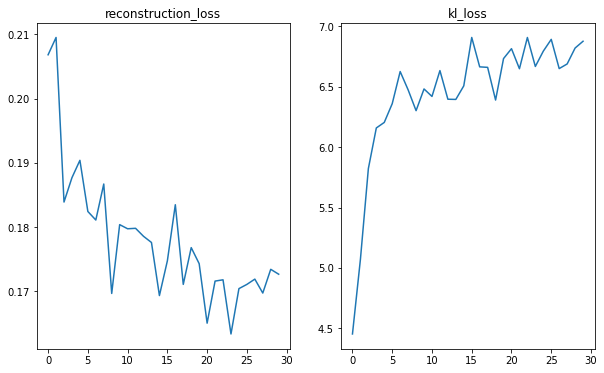

In [19]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=30, batch_size=128)
plot_loss(history)

##[TO COMPLETE] Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

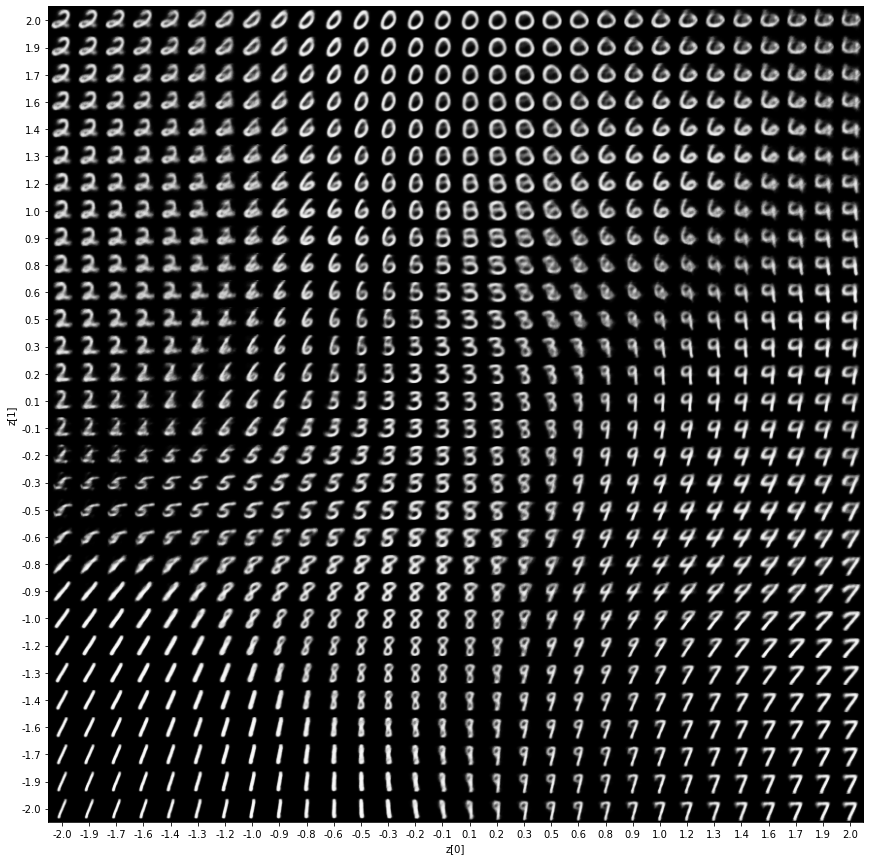

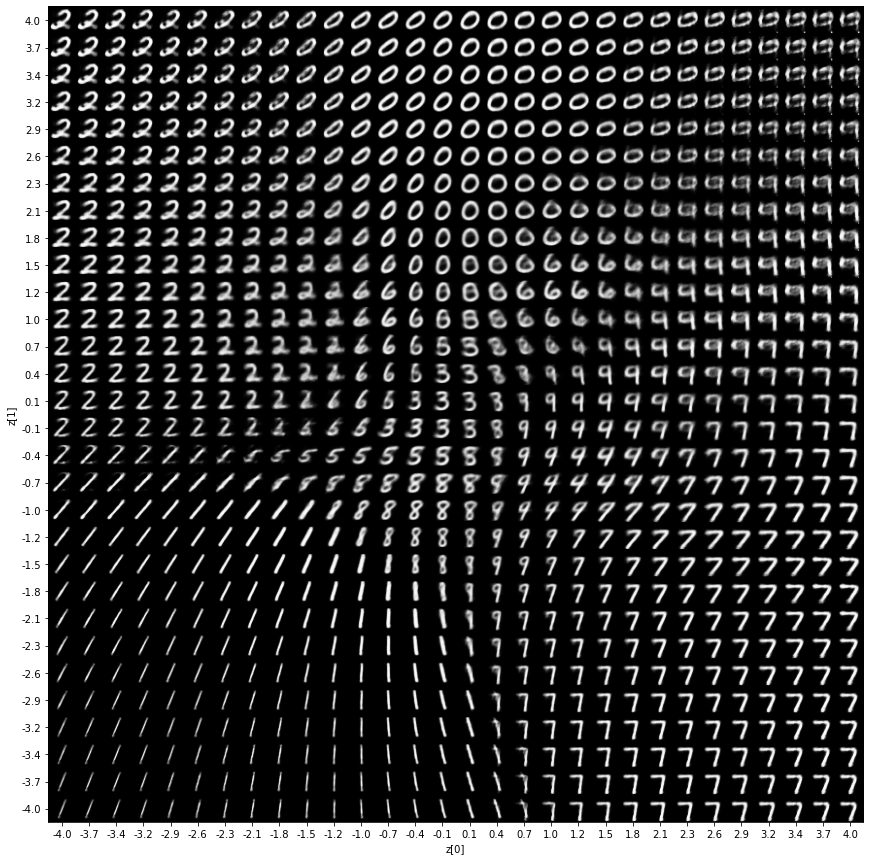

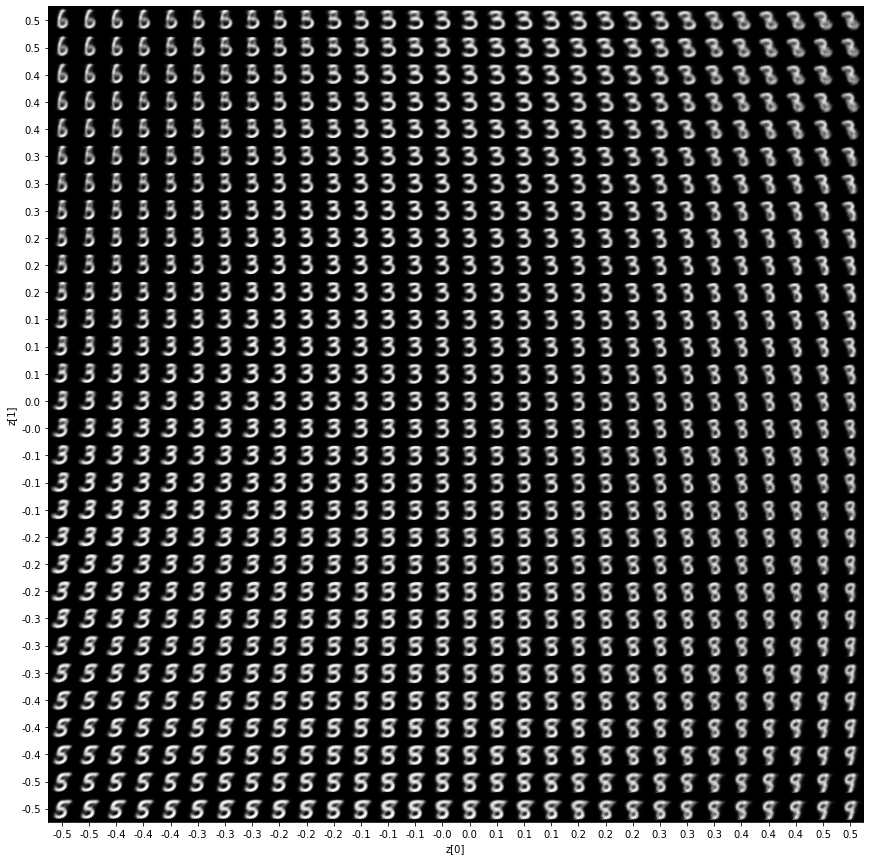

In [20]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 30) 

#[TO COMPLETE] explore what happens with different "scales"
for scale in (4, .5):
  plot_latent(encoder, decoder, scale, 30) 

The final result is quite impressive, considering that all these digits are artificial and they not belong to any dataset!
Let's finally check how the various digits have been represented in the latent space by the VAE.

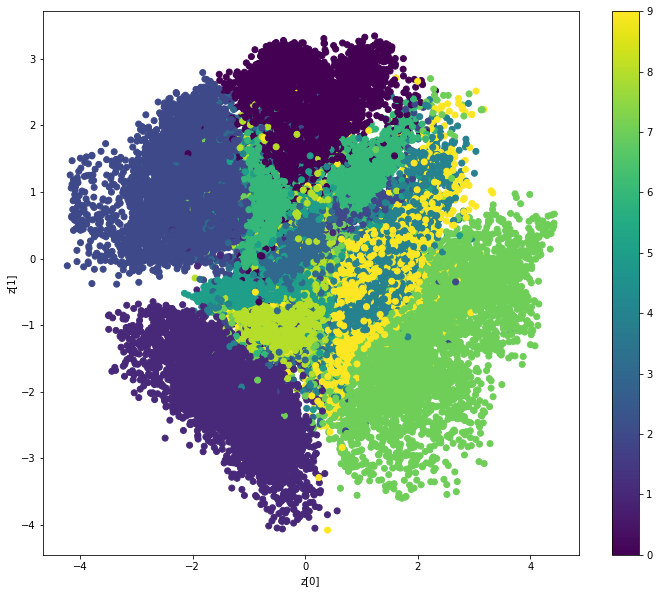

: 

In [21]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**[TO COMPLETE]** Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.

**Answer:** 

Since the KL Divergence is initially some orders of magnitude higher than the real loss (reconstruction loss) and so the optimizer optimization is directed especially towards the KL_loss, the reconstruction loss remains almost the same. So I added a hyperparamter to balance the ratio between the two losses in order to obtain some important improvements also on the reconstruction loss. If this parameters is near 1 we obtain very blurred digits in output, since the optimizer tends to uniform the distribution towards a standard normal distribution. Elsewhere, if the parameter is some order of magnitude lower than 1 then the optimizer prefers a better reconstruction; in this case the digits can be usually clearly distinguishable, but the distribution of the latent space tends to be no more a standard normal. However viewing the last plot we can see that the distribution is clearly near the standard: the mean is around the center (zero vector) and the majority of the points are included in a circle of radius  3σ  with  σ=1 .

With the scale of 4 we can clearly see all digits in the plot, and with a scale of 0.5 we can see more samples of the same digits. This because the scale is parametrizing the variance.
